# Fractional GD

In [2]:
library('fracdiff')

Warning message:
"package 'fracdiff' was built under R version 4.1.3"


In [3]:
caputo.derivative <- function(x, s, deriv, a=0)
{   
    if(deriv(x)==0){return(0)}
    integrand <- function(tau) {(1/gamma(1-s))*deriv(tau)/(x-tau)**s}
    return(integrate(integrand, lower = a, upper = x)$value)
}
v.caputo.derivative <- Vectorize(caputo.derivative, "x")

In [62]:
x <- c(10, 10, 10)
t1 <- 0.1
t2 <- 0.1
grad <- function(z){2*z}
error <- NULL
for(i in seq(1, 100))
{
    y <- tail(x,1) +(i-1)/(i+2)*tail(diffseries(x, d=0.9),1)
    # print(y)
    # y <- tail(x, 1)+(i-1)/(i+2)*(tail(x,1)-rev(x)[2])
    # print(y)
    x <- c(x, y-t2*grad(y))
    error <- c(error, tail(x, 1)**2)
}

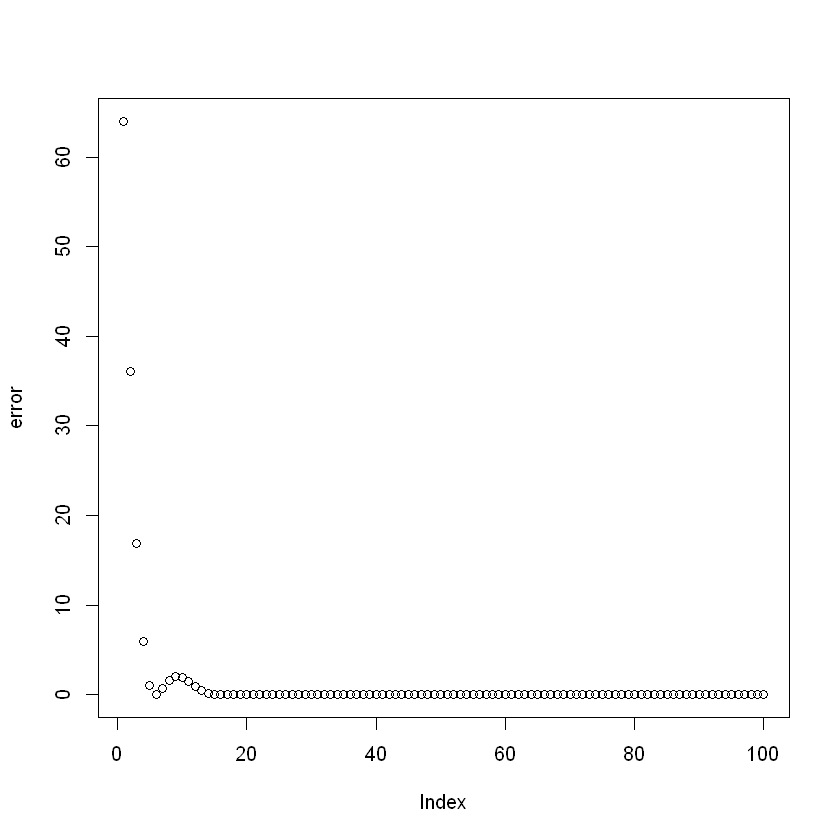

In [63]:
plot(error)


In [42]:
x <- c(10)
t2 <- 0.1
grad <- function(z){2*z}
error <- NULL
for(i in seq(1, 100))
{
    x <- x-t2*grad(x)
    error <- c(error, x**2)
}

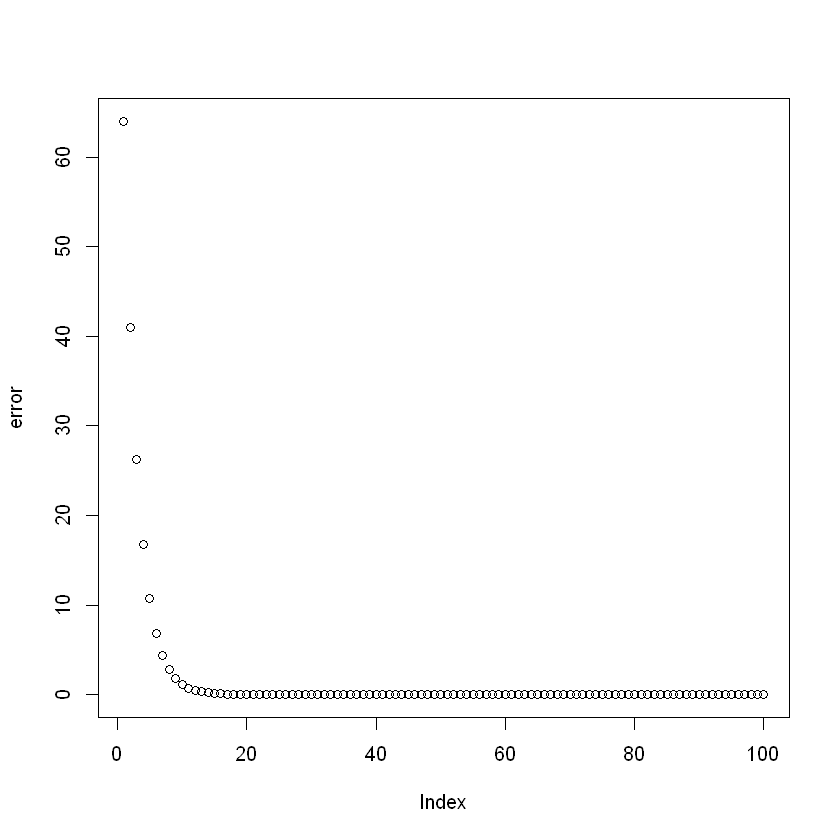

In [43]:
plot(error)

In [64]:
generate_data <- function(n=200, d=100, s=2, seed =42) 
{
    set.seed(seed)
    beta <- numeric(length = d)
    beta [1:s] <- 1
    X <- matrix(rnorm(n*d), nrow=n, ncol=d)
    y <- c(X %*% beta) + rnorm(n)
    list(X=X, y=y, beta=beta)
}
data <- generate_data(n=1000, d=400, s=4, seed =58)

In [ ]:
l2.norm <- function(a) {sqrt(sum(a*a))}
loss <- function(X, y, beta){0.5*l2.norm(X%*%beta-y)**2}

gd_step.frac_acc<- function(x, y, beta, t, i, s=0.9)
{
    v <- tail(x,1) +(i-1)/(i+2)*tail(diffseries(beta, d=s),1)
    return(v-t*t(X)%*%(X%*%v-y))
}


fit <- function(alg, X, y,beta_true=NULL,max_iter=50, t=1)
{
    d <- dim(X)[2]
    beta = numeric(length=d)
    betas = list(beta, beta)
    loss <- NULL
    error <- NULL
    iter <- 0
    t<-t/hess.loss.max(X)
    while(iter<max_iter)
    {
        iter <- iter+1
        y_hat <- X%*%beta
        if(alg=='acc'){betas <- append(betas,list(gd_step.acc(X, y, beta, t)))}
        else if(alg=='frac_acc'){beta <- gd_step.frac_acc(X, y, beta, t)}
        else {stop('invalid algorithm')}
        loss <- c(loss, loss(X, y, beta))
        if(!is.null(beta_true))
        {
            log_loss <- log(tail(loss, 1))-log(loss(X, y, beta_true))
            error <- c(error, log_loss)
        }
        if(iter==early_stop){break}
    }
    return(list(y_pred=X%*%beta, beta=beta, loss=loss/length(y),  error=error))
}